# File Preprocessing  

In [175]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt

In [176]:
cwd_path = Path.cwd()

In [177]:
og_train_path = os.path.join(cwd_path, "fruits-360/Training")
og_test_path  = os.path.join(cwd_path, "fruits-360/Test")

In [178]:
def getRandomFruitDirs(classCount):
    return np.random.choice(os.listdir(og_train_path), classCount, replace=False)

In [179]:
def MakeDirs(srcDir, newDirs):
    
    if type(newDirs) == str: 
        dirpath = os.path.join(srcDir, newDirs)
        if os.path.isdir(dirpath): 
            shutil.rmtree(dirpath)
        
        os.mkdir(dirpath)
    
    
    if type(newDirs) == list:    
        for dirname in newDirs:
            dirpath = os.path.join(srcDir, dirname)
            if os.path.isdir(dirpath):
                shutil.rmtree(dirpath)
        
            os.mkdir(dirpath)

In [180]:
def transferFile(srcPaths, destDir):
    if not os.path.isdir(destDir):     
        os.mkdir(destDir)
        
    for idx, imagePth in enumerate(srcPaths): 
        dPath = os.path.join(destDir, f"img{idx}.jpg")
        os.symlink(imagePth, dPath)
    

In [181]:
def getImageMatrix(links, title, image_size):

    sub_matrix = np.zeros(image_size[0] * image_size[1] * 3)
    labels = []
    for link in links: 
        vect_item = cv2.imread(link)
        vect_item = cv2.resize(vect_item, image_size)
        vect_item = cv2.cvtColor(vect_item, cv2.COLOR_BGR2RGB)
        sub_matrix = np.vstack((sub_matrix, vect_item.flatten()))
        labels.append(title)
        
    return sub_matrix[1:]/255, np.array(labels)

In [182]:
def getSamplesDir(sampleSize, valSize, testSize, selectedFruits, classDist = None): 
    trainSize = 1 - (valSize + testSize)
    train_fn = []
    test_fn = []
    val_fn = []

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")

        
    if testSize <= 0: 
        raise Exception("Training sample size too small!")

    train_sample_sz = int(trainSize * sampleSize)
    val_sample_sz = int(valSize * sampleSize) 
    test_sample_sz = int(testSize * sampleSize)

    subset_dir = "ML_FINAL_PROJECT/fruits-360"
    MakeDirs(subset_dir, "Subsets")
    
    subset_dir = "ML_FINAL_PROJECT/fruits-360/Subsets"
    
    subs = ["Train_sub", "Validation_sub", "Test_sub"]
    MakeDirs("ML_FINAL_PROJECT/fruits-360/Subsets", subs)

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        train_fn = np.random.choice(globbed_train, int(train_sample_sz * cDist[idx]), replace = False)
        testval_fn = np.random.choice(globbed_test, int((test_sample_sz  + val_sample_sz)*cDist[idx]), replace = False)

        test_fn, val_fn = testval_fn[ : int(test_sample_sz * cDist[idx])],  testval_fn[int(test_sample_sz * cDist[idx]) + 1 :]
        
        transferFile(train_fn, os.path.join(subset_dir, subs[0], fruit))
        transferFile(val_fn, os.path.join(subset_dir, subs[1], fruit))
        transferFile(test_fn, os.path.join(subset_dir, subs[2], fruit)) 

In [183]:
def getSamplesMat(sampleSize, selectedFruits, classDist = None, resize = (100, 100)): 
    matrix = np.zeros(shape = (1, resize[0] * resize[1] * 3))
    labels = np.zeros(0)

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")
        return 
        

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        fn = np.random.choice(globbed_train + globbed_test, int(sampleSize * cDist[idx]) ,replace = False)
        res_matrix, new_labels = getImageMatrix(fn, fruit,resize)        
        
        matrix = np.vstack([matrix, res_matrix])
        labels = np.concatenate([labels, new_labels])
        
    return matrix[1:], labels, fn[0]

# SVM's
## Testing similar color but different shapes

In [184]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

sample_size = 300
classDist = None
resizes = (100,100)

              precision    recall  f1-score   support

        Corn       1.00      1.00      1.00        31
       Lemon       1.00      1.00      1.00        29

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



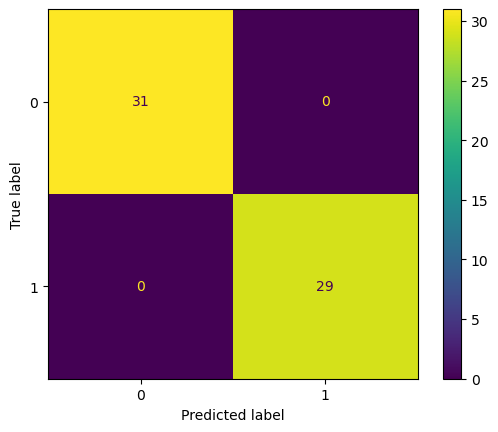

In [185]:
#Testing Lemon and corn
fruits = ["Lemon", "Corn"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

    Eggplant       1.00      1.00      1.00        29
        Plum       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



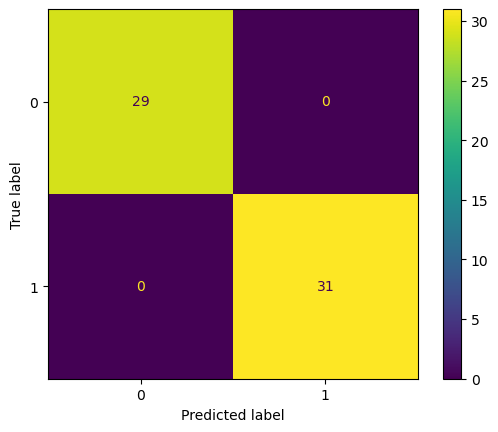

In [186]:
#Testing Eggplant and Plum
fruits = ["Eggplant", "Plum"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

 Apple Red 2       1.00      1.00      1.00        22
  Pepper Red       1.00      1.00      1.00        16
  Strawberry       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



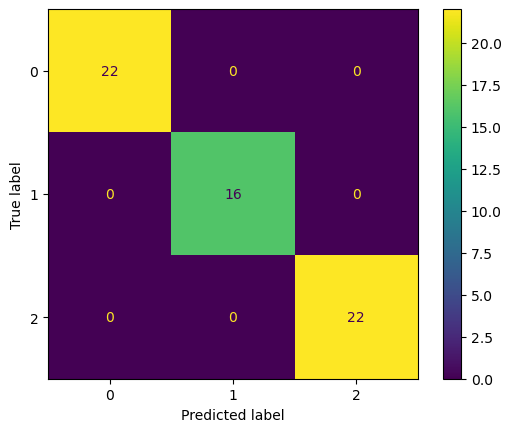

In [187]:
#Testing Lemon and corn
fruits = ["Strawberry", "Pepper Red", "Apple Red 2"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Testing similar shape but different colors

              precision    recall  f1-score   support

   Onion Red       1.00      1.00      1.00        29
 Onion White       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



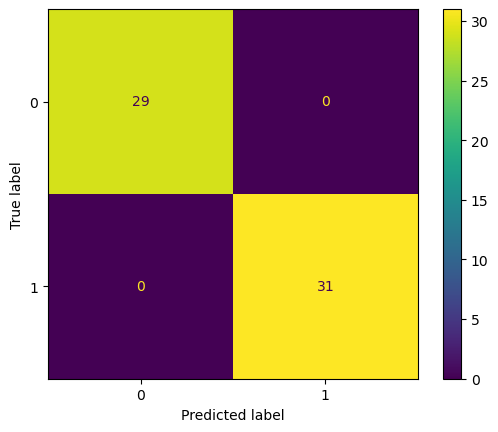

In [188]:
#Testing onion red and onion white
fruits = ["Onion Red", "Onion White"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

Pepper Green       1.00      1.00      1.00        29
  Pepper Red       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



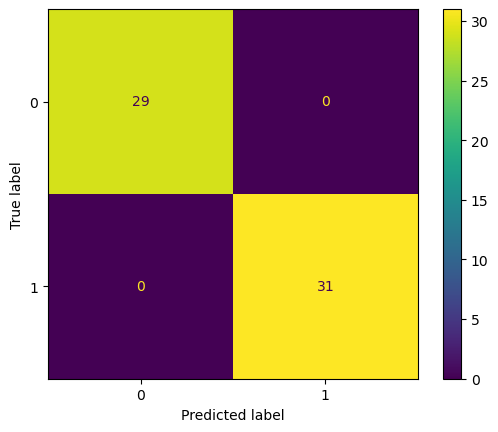

In [189]:
#Testing pepper green and pepper red
fruits = ["Pepper Green", "Pepper Red"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

Cantaloupe 1       1.00      1.00      1.00        22
      Walnut       1.00      1.00      1.00        16
  Watermelon       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



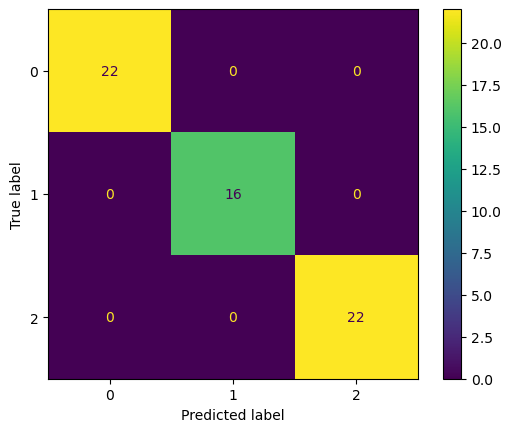

In [190]:
#Testing Cantaloupe 1, Walnut, and Watermelon
fruits = ["Cantaloupe 1", "Walnut", "Watermelon"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Very similar fruits

                   precision    recall  f1-score   support

         Cherry 2       1.00      1.00      1.00        31
Tomato Cherry Red       1.00      1.00      1.00        29

         accuracy                           1.00        60
        macro avg       1.00      1.00      1.00        60
     weighted avg       1.00      1.00      1.00        60



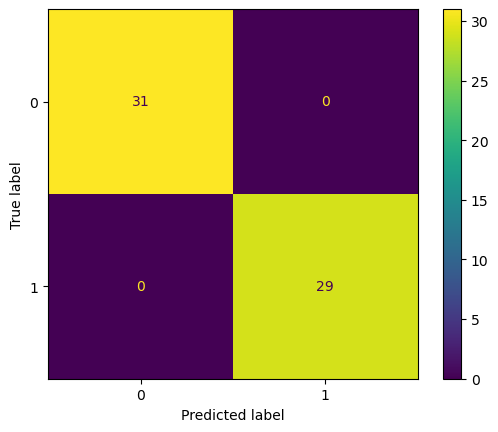

In [191]:
#Testing Tomato Cherry Red, Cherry 2
fruits = ["Tomato Cherry Red", "Cherry 2"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

      Orange       1.00      1.00      1.00        31
    Physalis       1.00      1.00      1.00        29

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



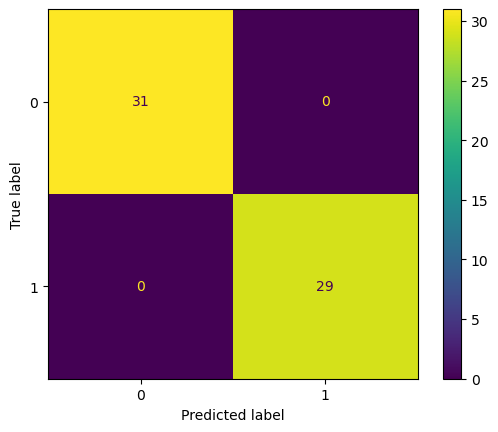

In [192]:
#Testing Physalis and Orange
fruits = ["Physalis", "Orange"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

                precision    recall  f1-score   support

Apple Golden 1       1.00      1.00      1.00        22
Apple Golden 2       1.00      1.00      1.00        16
Apple Golden 3       1.00      1.00      1.00        22

      accuracy                           1.00        60
     macro avg       1.00      1.00      1.00        60
  weighted avg       1.00      1.00      1.00        60



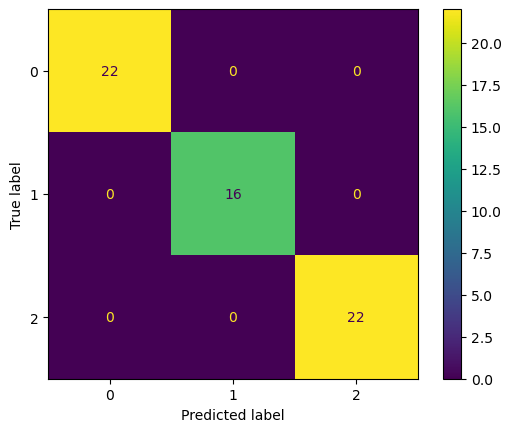

In [193]:
#Testing Apple Golden 1, Apple Golden 2, Apple Golden 3
fruits = ["Apple Golden 1", "Apple Golden 2", "Apple Golden 3"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()